# Covid19 Research Project

![alt text](https://img.evbuc.com/https%3A%2F%2Fcdn.evbuc.com%2Fimages%2F100281054%2F307358662756%2F1%2Foriginal.20200505-230250?w=600&auto=format%2Ccompress&q=75&sharp=10&rect=0%2C60%2C1920%2C960&s=bf03a264ea60190cbbf3eb3f4b874c0f)


Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus.

Most people infected with the COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment. Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness.

The best way to prevent and slow down transmission is be well informed about the COVID-19 virus, the disease it causes and how it spreads. Protect yourself and others from infection by washing your hands or using an alcohol based rub frequently and not touching your face.



 Research Question: 
#### **Can a machine learning model predict future infections?**

Predictive modelling helps governments and healthcare systems take precautionary steps.

To do this, we are going to answer 3 smaller questions, 
- What are the countries with the most COVID19 infections?
- What are infection rates going to be like for countries in the future?
- What are the predicted deaths caused by COVID19 in countries around the world?

### Step 0) Importing Necessary Files

We are going to be importing the following libraries
- Pandas - data analysis/manipulation
- Numpy - scientific computing
- Matplotlib - Plotting/Visualization
- PyPlot - Matplotlib Sub Library
- Prophet - Prediction Framework
- Seaborn - data visualization

%matplotlib inline  - Makes it look nice 💯 (Formats the output of the plots)

*We use `as` to create nicknames that are easier to type  

In [0]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from fbprophet import Prophet
import seaborn as sns
%matplotlib inline

### Load and Explore the Data

Loading the csv data from Github and create a pandas dataframe.

I like to think of the Pandas Dataframe almost like an excel table. You have rows and columns of data. However, in Pandas, the data in the columns must be of the same data type. The Pandas Series is just one column from the Pandas DataFrame.


In [0]:
#Load the csv data, creating pandas dataframe by persisting date format
world_df = pd.read_csv('https://raw.githubusercontent.com/bitprj/covid19/master/covid_data.csv',parse_dates=['Date'])

`df.head()` Returns the first 5 rows of the dataframe. To override the default, you may insert a value between the parenthesis to change the number of rows returned. Example: df.head(10) will return 10 rows.

In [40]:
#Display top 5 records
world_df.head(5)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


**Dataset Infomation**

*   Id - Serial Number 
*   Province_State - Respective State of the Country
*   Country_Region - Country Name
*   Date : Date(yyy-mm-dd) format
*   ConfirmedCases : Total cases till provided date(It's a cumilative number)
*   Fatalities : Total deaths till provided date(It's a cumilative number)

`df.describe()` Provides descriptive statistics that summarizes the central tendency, dispersion, and shape.

In [41]:
#view some basic statistical details like percentile, mean, std 
world_df.describe()

,Id,ConfirmedCases,Fatalities
count,27231.000000,27231.000000,27231.000000
mean,17828.000000,1372.808050,75.991444
std,10300.673333,9488.242361,808.719059
min,1.000000,0.000000,0.000000
25%,8914.500000,0.000000,0.000000
50%,17828.000000,2.000000,0.000000
75%,26741.500000,138.000000,1.000000
max,35655.000000,230597.000000,22745.000000


`df.info() `Provides a summary of the data including the index data type, column data types, non-null values and memory usage.

In [42]:
world_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27231 entries, 0 to 27230
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Id              27231 non-null  int64         
 1   Province_State  11571 non-null  object        
 2   Country_Region  27231 non-null  object        
 3   Date            27231 non-null  datetime64[ns]
 4   ConfirmedCases  27231 non-null  float64       
 5   Fatalities      27231 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.2+ MB


#### QAing the Data
Before we start data analysis, we have to determine if there are any anomalies with the data. 

In [43]:
#whether the data frame has any NAN values
world_df.isnull().values.any()

True

`.isnull().sum() `Returns count of null values

In [44]:
#whether the data frame has any NAN values
world_df.isnull().sum()

Id                    0
Province_State    15660
Country_Region        0
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64

### Preprocessing the data

Only Province_State column has 15660 NAN values.There are multiple approaches to fill the values. Replacing NAN values with blank as data is partially available in this column

In [0]:
#Replace NAN values with blank string
world_df.fillna({'Province_State': ""},inplace=True)

#Drop unusefull columns if any 
world_df.drop("Id",axis=1,inplace=True)

### Data Visualizations

Total world wide Covid-19 cases and deaths representation

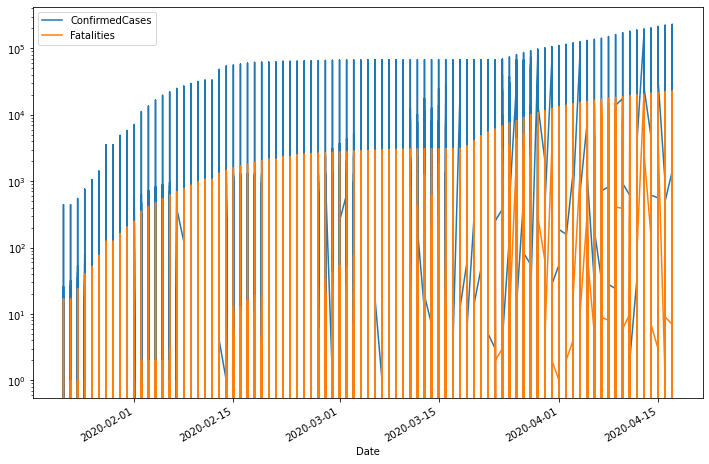

In [69]:
#bar chart for total confirmed and fatalities cases
axis = world_df[['Date','ConfirmedCases','Fatalities']].set_index('Date').plot(figsize=(12, 8),logy=True)
plt.show()

In [74]:
world_df.groupby('Country_Region')['ConfirmedCases'].sum().reset_index()

,Country_Region,ConfirmedCases
0,Afghanistan,9974.0
1,Albania,9123.0
2,Algeria,32931.0
3,Andorra,12415.0
4,Angola,319.0
...,...,...
179,Vietnam,7210.0
180,West Bank and Gaza,5930.0
181,Western Sahara,64.0
182,Zambia,903.0


In [0]:
def mostEffectedCountries(world_df):
  """
  The function displays most effected countries in descending order. 

        Parameters: 
            world_df (DataFrame): The Dataframe to be processed       
        Returns: 
            country_df: A Dataframe which contains most effected countries cases sum
  """
  country_df = world_df.groupby('Country_Region')['ConfirmedCases'].sum().reset_index()
  country_df.sort_values(["ConfirmedCases"],ascending=False,inplace=True)
  return country_df


In [0]:
country_df = mostEffectedCountries(world_df)

 10 hotspots of covid19 cases

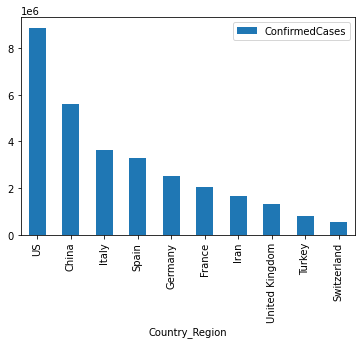

In [49]:
top_count = 10
country_df[:top_count].plot.bar(x='Country_Region',y = 'ConfirmedCases');

Write `ConfirmedCasesStateWise` function to display confirmed cases with county and statewise groping

Parameters
- df (dataframe) : The dataframe to be processed
- country (str) : Should be valid county 
name
  
Returns:  
- state_df (dataframe) - Returns most corona confirmed cases statewise data

In [0]:
def ConfirmedCasesStateWise(df,country):
  country_df = df[df.Country_Region == country][['Province_State','ConfirmedCases']]
  state_df = country_df.groupby('Province_State')['ConfirmedCases'].sum().reset_index()
  state_df.sort_values('ConfirmedCases',ascending=False,inplace=True)
  return state_df 

 Write `FatalitiesStateWise` function to display death cases with county and statewise groping

  Parameters
- df (dataframe) : The dataframe to be processed
- country (str) : Should be valid county name

Returns:  
- state_df (dataframe) - Returns most corona confirmed cases statewise data

In [0]:
def FatalitiesStateWise(df,country):
  country_df = df[df.Country_Region == country][['Province_State','Fatalities']]
  state_df = country_df.groupby('Province_State')['Fatalities'].sum().reset_index()
  state_df.sort_values('Fatalities',ascending=False,inplace=True)
  return state_df

Total 10 hotspot cases states of covid19 cases within US

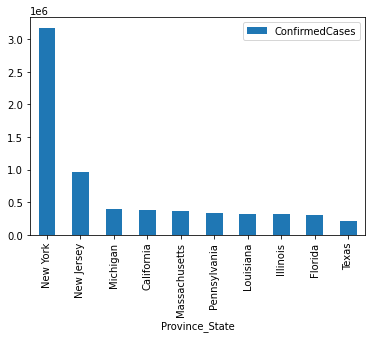

In [52]:
#Funtion works for any valid county code/name within the dataset
country = 'US'
state_df = ConfirmedCasesStateWise(world_df,country)
state_df[:10].plot.bar(x='Province_State',y = 'ConfirmedCases');

Total 10 Fatalities states of covid19 cases within US

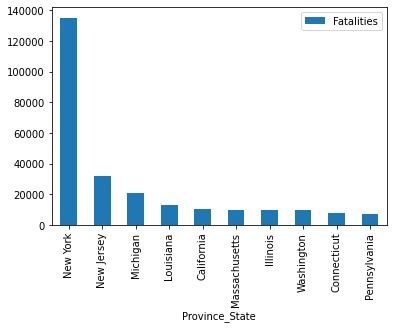

In [53]:
country = 'US'
state_death_df = FatalitiesStateWise(world_df,country)
state_death_df[:10].plot.bar(x='Province_State',y = 'Fatalities');

### Answer Questions

**Q1). Most death rated countries?**
    
Simple Data Analysis and processing can answer this question by using basic mathematic formula (total deaths/total cases)* 100

#### Analysis
  Write `highestDeathRate` function displays highest death rated country. 

  Parameters: 
- df (DataFrame): The Dataframe to be processed       
  Returns: 
- total_df (DataFrame): Sorted descending death rate countries

In [0]:
def highestDeathRate(df):
  #grouping Fatalities data country wise
  country_death_df = df.groupby('Country_Region')['Fatalities'].sum().reset_index()
  #grouping ConfirmedCases data country wise
  country_cases_df = df.groupby('Country_Region')['ConfirmedCases'].sum().reset_index()
  #merging two dataframes
  total_df = country_death_df.merge(country_cases_df)
  #calculating death rate by (total deaths/total cases)* 100
  total_df['DeathRate']   = (total_df.Fatalities / total_df.ConfirmedCases)*100
  #To sort descending order
  total_df.sort_values('DeathRate',ascending=False,inplace=True)
  #Resetting indexes
  total_df.reset_index(inplace=True)
  #drop unused columns here
  total_df.drop(["index","ConfirmedCases","Fatalities"],axis=1,inplace=True)
  return total_df


In [0]:
#calling highestDeathRate function get Highest death rate countries
most_death_rate = highestDeathRate(world_df)
#top 5 display
most_death_rate = most_death_rate.head(20)

#### Visualize

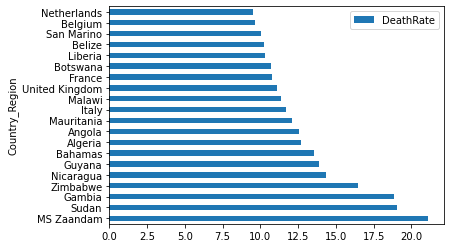

In [56]:
#plottingbar chart to display most death rated countries
axis = most_death_rate.plot.barh(x='Country_Region',y = 'DeathRate');
plt.show()

Most death rated countries are displayed through bar chart.
If notice most of them are economically poor countries. Their health care system would be very minimal. 

In order to answer question 2 & 3, need to build a model which helps providing predictions.

Developed a few generic functions for the same for reusability purpose

### Train and Test data split
This functions prepare train test data split

**Parameters**
- df (dataframe) : The dataframe to be processed
- period (int) : Test dataset size(default is 5 days)

**Returned Data**
- train_data (dataframe) - train set to train the model
- test_data (dataframe) -  test set to train the model




In [0]:
def train_test_data_split(df,period=5):
  #Excluding last 5 for the training set
  train_data = df[:-period]
  #Including last 5 for the test set
  test_data =  df[-period:]
  return train_data,test_data

### Prophet Model Training
Facebook's Prophet framework is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. The modeling function helps in build and deploy the model

**Parameters**

```
train_data (dataframe) - train set to train the model
```

**Returned Data**

```
pm (prophet object) -  prophet object to run the predictions
```

If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument `changepoint_prior_scale`. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible:

In [0]:
def modeling(train_data):
  #Prophet algorith helps to predict the time series data
  pm = Prophet(changepoint_prior_scale=0.95,interval_width=1)
  #training the model
  pm.fit(train_data)
  return pm

### Predictions
This functions helps in run the predictions

**Parameters**

```
pm (prophet object) -  prophet object to run the predictions
```

```
periods(int) - Number of days for predictions
```


**Returned Data**

```
pm_forecast (dataframe) -  dataframe with predictions
```

In [0]:
def predictions(pm,periods=5):
  #considering 5 future days
  future = pm.make_future_dataframe(periods)
  #predicting provided days
  pm_forecast = pm.predict(future)
  return pm_forecast

### Model Evaluation
The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in statistics, for example in trend estimation, also used as a loss function for regression problems in machine learning. It usually expresses the accuracy as a ratio defined by the formula:

TL;DR - On average, how does the forecasted values deviate (percentage wise) from the actual values. 

    This functions helps to evaluate the model

    Parameters
      y_true (dataframe) -  test dataset
      y_pred(dataframe) - predicted dataset
    Returns:  
      mape (int) -  integer

To calculate the deviation, we use numpy's .abs function to calculate the deviation of the true value from the prediction. 

In [0]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#### Helper Function
Main function which helps to run the data preparation,model execution, predictions and evaluations

    Parameters
    world_df (dataframe) -  Dataframe which loaded through csv
    countries (list) - comma seperated list of countries 

In [0]:
def helper(df,countries):
    train_data,test_data = train_test_data_split(df,5)
    pm = modeling(train_data)
    predictions_df = predictions(pm,5)
    results_df = predictions_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(test_data)
    print(results_df)
    fig1 = pm.plot(predictions_df)
    fig1.suptitle(country,verticalalignment='center')
    fig2 = pm.plot_components(predictions_df)
    fig2.suptitle(country,verticalalignment='center')
    print(country+' MAPE: '+str(mean_absolute_percentage_error(results_df['yhat'].iloc[0], results_df['y'].iloc[0])))
    return results_df

#### Analysis

#### Q2) Predict future cases for a given country?

This functions prepare data country wise for predictions

  Parameters
    df (dataframe) : The dataframe to be processed
    country (str) : Should be valid county name
  Returns:  
    country_rn_df (dataframe) - Returns most country wise dataset


In [0]:
def countryWiseCasesPredictions(df,country):
  #grouping country wise
  country_df = world_df.groupby(['Country_Region','Date'])[['ConfirmedCases','Fatalities']].sum().reset_index()
  #filtering provided country data
  country_df = country_df[country_df.Country_Region == country]
  #Renaming column as per the models needs
  country_rn_df = country_df.rename(columns={"Date":"ds","ConfirmedCases":"y"})
  #Dropping unused columns
  country_rn_df = country_rn_df.reset_index().drop(["index","Fatalities","Country_Region"],axis= 1)
  return country_rn_df


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds          yhat    yhat_lower    yhat_upper        y
0 2020-04-13  25251.232894  24147.100226  26306.352819  25667.0
1 2020-04-14  26524.512833  25698.009215  27715.013249  27022.0
2 2020-04-15  27778.315774  26841.125892  28872.583455  28196.0
3 2020-04-16  29117.606407  27509.344453  30493.712802  30796.0
4 2020-04-17  30313.606638  28414.470216  32459.885694  32801.0
Canada MAPE: 1.6465220062708334


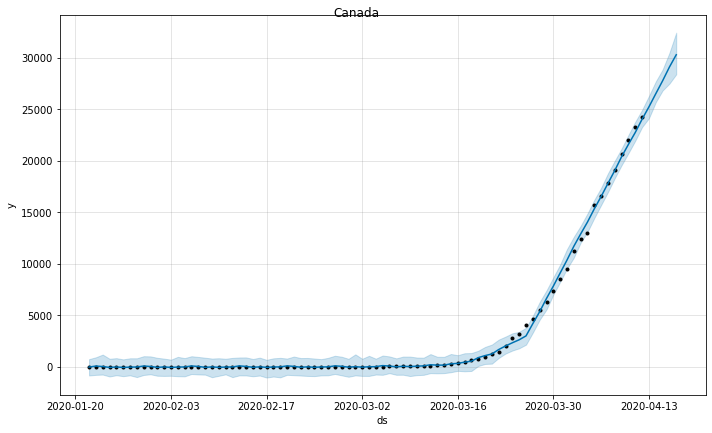

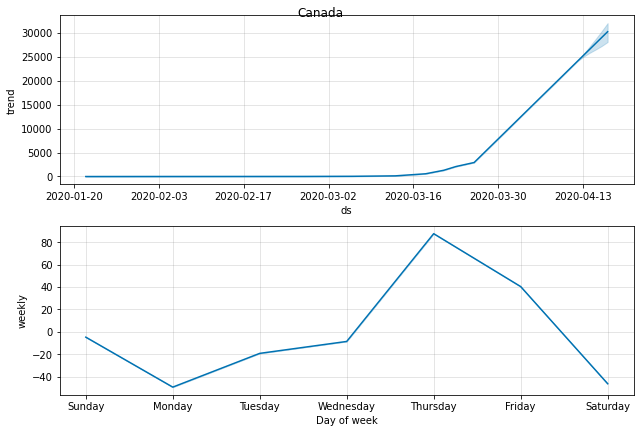

In [63]:
#Comma sepearted list for predictions
# countries = ['China','Thailand','Canada']

countries = ['Canada']
for country in countries:
   df = countryWiseCasesPredictions(world_df,country)
   results = helper(df,countries)
   results.head()

The results are very promising. The error rate is just 0.08 and Forecasted data is within the boundary.

**3. Predict total deaths for a given country?**

Write a function to prepare data for predictions

**Parameters**
- df (dataframe) : The dataframe to be processed
- country (str) : Should be valid county name
- state (str) : Should be valid state name
 
**Returns**:  
- state_rn_df (dataframe) - Returns most state wise dataset

In [0]:
def countryWiseDeathPredictions(df,country):
  #grouping country wise
  q3_df = df.groupby(['Country_Region','Date'])[['ConfirmedCases','Fatalities']].sum().reset_index()
  #filtering provided country data
  q3_df = q3_df[q3_df.Country_Region == country]
  #Renaming column as per the models needs
  q3_rn_df = q3_df.rename(columns={"Date":"ds","Fatalities":"y"})
  #Dropping unused columns
  q3_rn_df = q3_rn_df.reset_index().drop(["index","ConfirmedCases","Country_Region"],axis= 1)
  return q3_rn_df

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds          yhat    yhat_lower    yhat_upper        y
0 2020-04-13  21179.870155  20744.746483  21695.648996  20465.0
1 2020-04-14  21857.573147  21334.458537  22393.777221  21067.0
2 2020-04-15  22522.393720  21381.388310  23488.147774  21645.0
3 2020-04-16  23157.651774  21970.828152  24592.252357  22170.0
4 2020-04-17  23880.256639  21978.906203  25702.608053  22745.0
Italy MAPE: 3.375233887325507


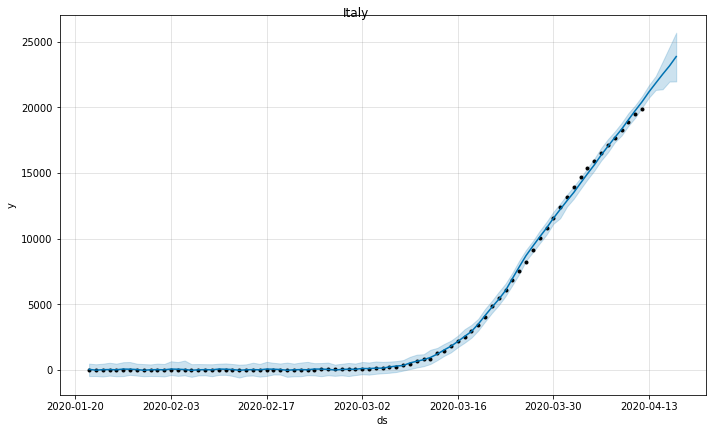

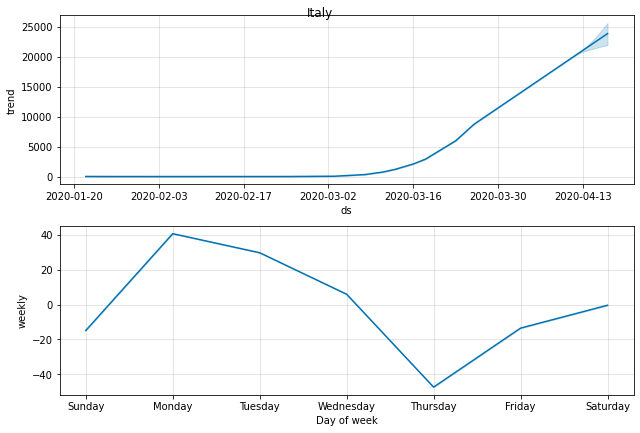

In [65]:
countries = ['Italy']
for country in countries:
   df = countryWiseDeathPredictions(world_df,country)
   results = helper(df,countries)
   results.head()

Cumulative deaths predictions from April-13 to April-17th

The error rate is 1.78

As per the graph, the death rate is growing exponentially here